# What Latency Can Tell Us About Emissions in Closed-Source LLMs
### *A Partial Model and a Call for Transparency*

Faryn Campbell

*July 2025*

[How to cite](#citation)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

from IPython.display import HTML, Image, Markdown, display

from token_latency_functions import (
    fastest_input_token_times_fig,
    fastest_output_token_times_fig,
    plot_latency_contributions_by_term
)

# 1  Introduction
It's likely you've heard or read about the concerning environmental impact of the GenAI explosion. I started paying closer attention about a year ago - and as a machine learning engineer whose role involves expanding access to large language models (LLMs), I became increasingly uneasy about the environmental footprint of both the models and my own work. I began looking for answers, but quickly discovered how little public data was available, since AI companies are being increasingly opaque about the impacts of their models ([Luccioni, Gamazaychikov, Alves da Costa, & Strubell, 2025](https://arxiv.org/abs/2506.15572)). Still, I wanted to find a way to estimate my company's AI carbon footprint. Since there was (and still is) no standard method of doing this, I set out to try to come up with an estimation method using something everyone can measure: latency.

In this paper, I propose, build, and evaluate a latency model for LLMs based on input and output tokens and then outline a theoretical framework for how this can be used to estimate emissions. The following will presume not *much* mathematical expertise and you're welcome to skip over the code blocks - they're just there to generate plots to illustrate my findings.

## 1.1 Background

To start with some background context, closed-source large language models (LLMs), like OpenAI's ChatGPT, Google's Gemini, and Anthropic's Claude, have (obviously) exploded in popularity in recent years. In April 2025, 15 of the top 20 most-used models were closed-source ([Luccioni and Gamazaychikov, 2025](https://huggingface.co/blog/sasha/energy-score-call-to-action)); that same month, OpenAI's CEO Sam Altman said in an interview that ChatGPT had close to 800 million weekly active users ([Paris [Forbes], 2025](https://www.forbes.com/sites/martineparis/2025/04/12/chatgpt-hits-1-billion-users-openai-ceo-says-doubled-in-weeks/)). However, there is currently little to no transparency from closed AI model providers about their energy consumption ([Luccioni, Gamazaychikov, Alves da Costa, & Strubell, 2025](https://arxiv.org/abs/2506.15572); [Luccioni and Gamazaychikov, 2025](https://huggingface.co/blog/sasha/energy-score-call-to-action)), despite widespread concerns about the climate impacts of AI ([Strubell, et al., 2019](https://arxiv.org/abs/1906.02243); [Luccioni et al., 2024](https://huggingface.co/blog/sasha/ai-environment-primer); [Luccioni, Strubell, and Crawford, 2025](https://arxiv.org/abs/2501.16548)). Consequently, estimating energy usage, emissions, and water consumption for closed-source LLMs has emerged as an important research area. While LLM training consumes substantial energy (among other impacts), inference (when users query the model) accounts for 80–90% of AI computing power ([O'Donnell and Crownhart, 2025](https://www.technologyreview.com/2025/05/20/1116327/ai-energy-usage-climate-footprint-big-tech/)). In this paper, I present a model to estimate response latency. Latency is an observable metric that serves as a practical proxy for how long data centers are actively processing a prompt, and consuming energy and emitting carbon in the process.

Many current estimates of energy at inference time are created in either a (1) 'top-down' manner, by gathering known energy usage figures and assigning proportions to model inference, or by (2) performing some closed-form calcluations to estimate hardware requirements. These estimates vary widely. Alex de Vries ([2023](https://www.cell.com/joule/fulltext/S2542-4351(23)00365-3?ref=thinkml.ai)), estimated that each ChatGPT request consumes approximately 3 watt-hours (Wh) of electricity. Despite its widespread citation, the underlying method has significant uncertainties. De Vries' estimate relies on assumptions made by SemiAnalysis [(2023)](https://semianalysis.com/2023/02/09/the-inference-cost-of-search-disruption/) that ChatGPT receives 195 million requests daily and uses 564 MWh per day, implying 2.9 Wh per request. Epoch AI [(2025)](https://epoch.ai/gradient-updates/how-much-energy-does-chatgpt-use) later challenged this, estimating 0.3 Wh per GPT-4o request (which is close to [Sam Altman's statement](https://blog.samaltman.com/the-gentle-singularity) that "the average [ChatGPT] query uses about 0.34 watt-hours"). MIT Technology Review journalists interviewed experts about the Epoch AI estimate. They said that "if anything, the real number is likely higher, not lower" ([O'Donnell and Crownhart, 2025](https://www.technologyreview.com/2025/05/20/1116327/ai-energy-usage-climate-footprint-big-tech/)). EcoLogits is an open-source project working toward comprehensively estimating the impact of LLM inference. Using their [Calculator](https://huggingface.co/spaces/genai-impact/ecologits-calculator) to replicate the variables in Epoch AI's estimate, they report 35.1 Wh per request (as of June 2, 2025). Their model takes more into account than Epoch AI's however, including the server consumption and embodied impacts. Notably, these estimates span two orders of magnitude - from 0.3 Wh on the low end to 35 Wh at the high end.

However, new research is providing more rigorous, fine-grained estimates. Jegham et al. ([2025](https://arxiv.org/abs/2505.09598)) evaluate assumptions for estimating emissions across 30 closed-source LLMs. For GPT-4o, they report 0.421 ± 0.127 Wh for 100 input and 300 output tokens; 1.214 ± 0.391 Wh for 1k input and 1k output; and 1.788 ± 0.363 Wh for 10k input and 1.5k output. Their data derive from [*Artificial Analysis*](https://artificialanalysis.ai/), which this work's latency model aims to improve. Fully replicating their methods to extend the current model is beyond this paper's scope but represents future work.

Notably, the largest query considered by Jegham et al. ([2025](https://arxiv.org/abs/2505.09598)) is 10,000 tokens. The EcoLogits Calculator only takes output tokens into account, completely ignoring input tokens. Yet as I show in this work, input tokens meaningfully impact inference time and, by extension, energy use and emissions. Moreover, behind-the-scenes transformations can substantially inflate the input size beyond what the user originally submitted.

## 1.2  The importance of input tokens
Typical user queries are fairly short. Jegham et al. ([2025](https://arxiv.org/abs/2505.09598)) defined a "short-form" prompt configuration as 100 input and 300 output tokens, medium as 1,000 input and 1,000 output, and long-form as 10,000 input and 1,500 output. While output tokens are the biggest drivers of latency, my work shows a notable impact when input and output are both large. But how often do prompts actually incur this extra latency?

While individual queries may be short, conversational messages usually include prior dialogue, and that history can fill the entire context window. Because input tokens are processed efficiently in parallel, providers likely use as much of the context window as possible to improve response quality. OpenAI recently announced that "[ChatGPT] now references all your past conversations to deliver responses that feel more relevant and tailored to you" (["Memory and new controls for ChatGPT"](https://openai.com/index/memory-and-new-controls-for-chatgpt/?utm_source=chatgpt.com)). Yet even for modest output sizes, these added input tokens can have a large effect. Assuming you're sending a short prompt when the model actually processes tokens up to the context window limit can drastically underestimate latency. New models have even larger context windows than studied here. For example, Google’s Gemini 2.5 Pro supports up to 1 million tokens ([Gemini 2.5 Pro](https://deepmind.google/models/gemini/pro/)). With such large limits, the risk of underestimating total input tokens grows even greater.

### 1.2.1  Hidden costs in reasoning models
While this work did not examine reasoning models, they highlight a second major source of hidden token usage. Reasoning language models are a class of model that iteratively reason through how to answer users' queries, generating tokens along the way. DeepSeek is one such model, and recent work showed that DeepSeek's responses are incredibly long, "the average response being 6,000 tokens long and some responses containing more than 20,000 tokens...which means that many responses are over 10 pages long" ([Werra et al., 2025](https://huggingface.co/blog/open-r1/update-1)). Preliminary research from HuggingFace has found that using reasoning with [Qwen3-8B](https://huggingface.co/Qwen/Qwen3-8B), an open-source large language model, required 43 times more energy than without reasoning ([Julien Delavande's Post](https://www.linkedin.com/posts/juliendelavande_i-asked-qwen3-8b-to-think-it-answered-activity-7323056592050921472-pdaP?utm_source=share&utm_medium=member_desktop&rcm=ACoAACFXjegBQyMZPb0Yo2HuXAo8_XEhznukF5s)). 

**Any model relying on token counts - whether for latency, energy, emissions, or cost estimates - risks underestimation if it overlooks tokens generated or consumed behind the scenes.**


## 1.3  My Contribution

The goal of this current work is to build towards an empirical estimate of energy consumption. As one key component of this estimate, I develop a model of response latency based on input (prompt) and output (response) tokens.

I study three OpenAI models: GPT-4o, GPT-3.5, and GPT-4. These were the most frequently used at my organization from October 2024 through December 2024. Although GPT-3.5 and GPT-4 are slated for deprecation, the methods and findings remain applicable to current and future non-reasoning models. The methods would need to be adjusted for reasoning models (like o1) and is outside the scope of this paper.

The contributions of this study to the existing literature are twofold:
1. I assemble and publish a novel dataset with data for nearly 7000 requests across the three models. I recorded both overall token counts and detailed per-token timing for each request.
2. Prior models of response latency assumed a constant "time to first token" (TTFT) plus a fixed cost per output token. However, I find that the TTFT varies with input size. Additionally, I identify and quantify a significant interaction term: as input and output tokens increase, they incur additional latency beyond a simple additive model. This implies even greater computational and emissions cost in real-world conversational settings, where input size can be longer than anticipated due to prior messages also being included in the context window.

While my ultimate aim is to extend this latency model to estimate emissions, research is still coming to a consensus on reasonable assumptions required to do so. Here, I focus on rigorously modeling response latency, one of the few metrics measurable from the client side for closed-source models.

---


# 2  Methods
In this section, I'll cover how I modeled latency, how I collected the latency data, and how I fit the models to that data.

## 2.1 The Model

Response latency has two main components: network latency, which includes data transit time and queuing and is not computationally intensive, and computational latency, during which the model is performing energy intensive computations.

$$
\text{Response Latency} = \text{Network Latency} + \text{Computational Latency}
$$

We can divide network latency into request and response components, and computational latency into two phases specific to decoder-only models: the *prefill* phase, during which the input is processed, and the *decode* phase, during which the output is generated iteratively.


$$
\text{Response Latency} = \text{network}_{request} + \text{network}_{response} + \text{compute}_{prefill} + \text{compute}_{decode}
$$

We can further model the computational latency of the prefill and decode phases as follows:

**Prefill.** In GPT models, the entire input is processed in an initial, parallelized forward pass known as the prefill phase. The computation time for this phase scales roughly linearly with the number of input tokens. A constant term $c$ captures the base latency for the shortest possible prompt, while the linear term accounts for the additional cost of processing longer inputs:

$$
\text{prefill} = c + \beta_n \cdot n
$$

where $n$ is the number of input tokens.

**Decode.** Although GPT models generate output tokens sequentially, reattending to the entire growing input at each step, the cost per output token remains roughly constant with efficient caching. As a result, output generation latency scales linearly with the number of output tokens. However, a small interaction term appears empirically, reflecting a slight increase in cost due to reattending when both input and output lengths are large:

$$
\text{decode} = \beta_m \cdot m + \beta_x \cdot (n \times m)
$$

where $m$ is the number of output tokens.

Combining all components, we can express the total response latency as:

$$
\text{Response Latency} = L + c + \beta_n \cdot n + \beta_m \cdot m + \beta_x \cdot (n \times m)
$$

where:

- $L$ is the **network latency**, composed of request and response times:  
  $L = \text{network}_{\text{request}} + \text{network}_{\text{response}}$
- $c$ is the base latency of the prefill phase
- $n$ is the number of input tokens
- $m$ is the number of output tokens


### 2.1.1  Network latency
Given my motivation of extending this model to estimate emissions, I aimed to isolate latency due to large language model (LLM) compute, excluding network latency as much as possible. In the framework I've written above, the only source of variation in overall response latency for the same inputs and number of output tokens is network latency. The computational latency, in this estimation framework, should not vary on repeated runs.[\*](#computational-latency)

In `network_latency.ipynb` I made a trivial request to OpenAI - specifically, a call to list available models that does not invoke any LLM. I repeated the request many times to account for variations in network traffic, then used the 10th percentile as a rough estimate of best-case, minimal network latency. 

$$
L = \text{Network Latency}_{Request} + \text{Network Latency}_{Response} = 0.1086 \text{ seconds}
$$

The quantile regression model aims to predict the 10th percentile for latency and, because in this model, the *only* source of variation in repeated runs for the same parameters is network latency, if we subtract this value from the observed 10th percentile response latency, we are in fact *entirely eliminating the network latency component from the equation.*

Subtracting $L$ leaves only the latency attributable to LLM computation, and the resulting model equation then becomes just:

$$
\text{Computational Latency} = \text{c} + \beta_n \cdot n + \beta_m \cdot m + \beta_x \cdot (n \times m)
$$

This latency model is, to my knowledge, novel. Typically, the time to first token (TTFT) is treated as a constant and does not vary with input size. The output generation time is then estimated by multiplying the number of output tokens by a tokens-per-second rate. However, this study shows that TTFT varies with input length, and the decode phase latency also depends on input size. Thus, this model more fully accounts for key factors influencing latency.

Next, I detail how I designed experiments to collect latency data to fit these models.


## 2.2 Data and Measurement Set Up
I prepared prompts to span the range of allowed input and output lengths for each model. The table below summarizes the context window, maximum output size, and *effective* maximum output size - the longest actual output I was able to obtain - for each model. Using the OpenAI API, I repeated each prompt multiple times, collecting timing and token data for each iteration. Repetitions ranged from 25 to 100: smaller prompts were run more frequently, while long, energy-intensive prompts were run fewer times. Responses were streamed, allowing token-level timing measurements as each output token was generated. Because no prompts were part of an ongoing chatbot conversation, no additional "memory" tokens were recorded. Token counts were obtained from the "usage" object returned by the API, which directly reports prompt, completion, cached, and reasoning tokens for billing. No cached or reasoning tokens were recorded for any request. I fit two types of linear regression models to this data, each predicting total computational latency as a function of input and output tokens.

| Model | Context Window (tokens) | Max Output Size (tokens) | Effective Max Output Size (tokens) |
| --- | --- | --- | --- |
| GPT-4o | 128,000 | 16,384 | ~4,000 |
| GPT-4 | 128,000 | 8,192 | ~2,000 |
| GPT-3.5 Turbo | 16,385 | 4,096 | ~4,000 |


## 2.3  Regression models
I fit two linear models to the adjusted latency data (i.e., with minimal network latency $L$ removed).

First, a **10th-percentile Quantile Regression**, which is used to estimate only latency due to large language model compute. The fastest 10% of observations are assumed to be requests minimally affected by network variability.

Second, an **Ordinary Least Squares (OLS) Regression** represents the average adjusted latency across all observations.


## 2.4 Model Justification
In this section, I justify the inclusion of linear terms for input and output tokens, as well as the addition of an interaction term.

**Linear terms for input and output tokens.** The plots below show that when output tokens are held constant, latency increases approximately linearly with the number of _input_ tokens. A similar linear relationship holds true vis-a-vis latency and _output_ tokens.

First, let's look at the 10% fastest latency observations as a function of *input* tokens:

/Users/faryn.campbell/Documents/scripts/llm-impact-taskforce/openai-latency-regression/token_latency_functions.py:216: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fastest_10 = input_times.groupby("input_tokens", group_keys=False).apply(


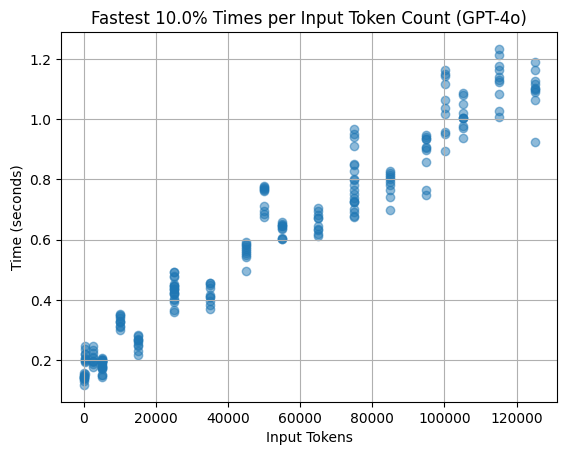

In [2]:
file_name = "network_latency/network_times.json"
with open(file_name, "r") as jf:
    network_times = json.load(jf)

network_latency = np.quantile(network_times, 0.1)

folder = "gpt-4o-2024-05-13/"
file_name = folder + "input_token_times.csv"
input_times = pd.read_csv(file_name)

file_name = folder + "output_token_times.csv"
output_times = pd.read_csv(file_name)

fastest_input_token_times_fig(
    input_times, "GPT-4o", network_latency, quantile=0.1
)

And second, the 10% fastest points as a function of *output* tokens:

/Users/faryn.campbell/Documents/scripts/llm-impact-taskforce/openai-latency-regression/token_latency_functions.py:268: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fastest_10 = output_times.groupby("token_bin", group_keys=False).apply(
/Users/faryn.campbell/Documents/scripts/llm-impact-taskforce/openai-latency-regression/token_latency_functions.py:268: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fastest_10 = output_times.groupby("token_bin", group_keys=False).apply(


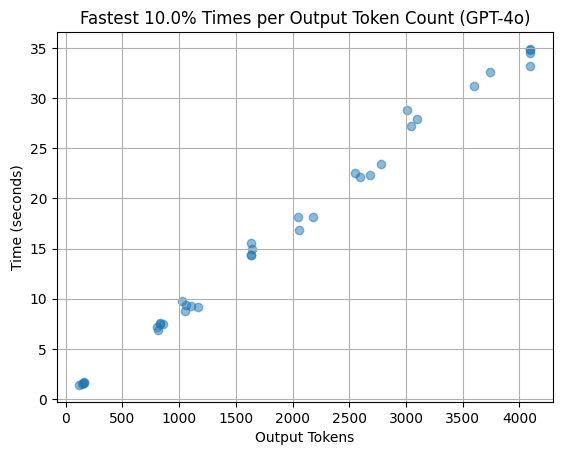

In [3]:
output_bins = range(0, 5000, 500)
fastest_output_token_times_fig(
    output_times, output_bins, "GPT-4o", network_latency, quantile=0.1
)

In both cases, the fastest observations fall neatly along a straight line, suggesting a minimal achievable latency that scales linearly with input or output size.

**Interaction term.** Under efficient key-value caching, output token generation is nearly linear. However, in decoder-only models like GPT, each new token attends to both the full input prompt and all previously generated tokens. While caching eliminates redundant matrix multiplications, self-attention still costs $\mathcal{O}\bigl((n + m)^2\bigr)$ in sequence length, where $n$ is the number of input tokens and $m$ is the number of output tokens. This quadratic overhead becomes noticeable when inputs and outputs are both long. The interaction term in the regression model captures this additional latency and is most visible in the plot below in the region where both input and output token counts are high.

In the last image of the plot below, comparing the bottom and top edges of the predicted latency surface highlights the impact of the interaction effect. Along the bottom edge, where output tokens are minimal, increasing input tokens leads to only a modest rise in latency, from under one second to about three seconds. In contrast, the top edge, where output tokens are large, shows a much steeper increase: latency starts around 40 seconds and climbs to about 60 seconds as input tokens grow. This steeper slope reflects the added cost from the interaction between long inputs and long outputs.

In [4]:
with open(folder + "ols_surface.html", "r") as f:
    html = f.read()

HTML(html)

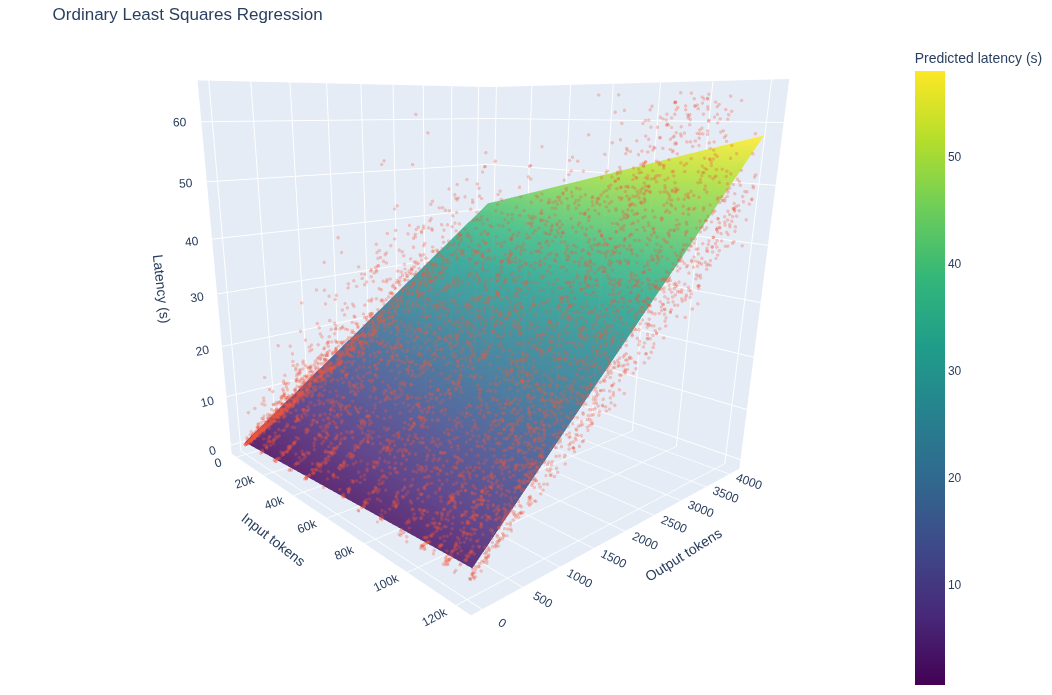

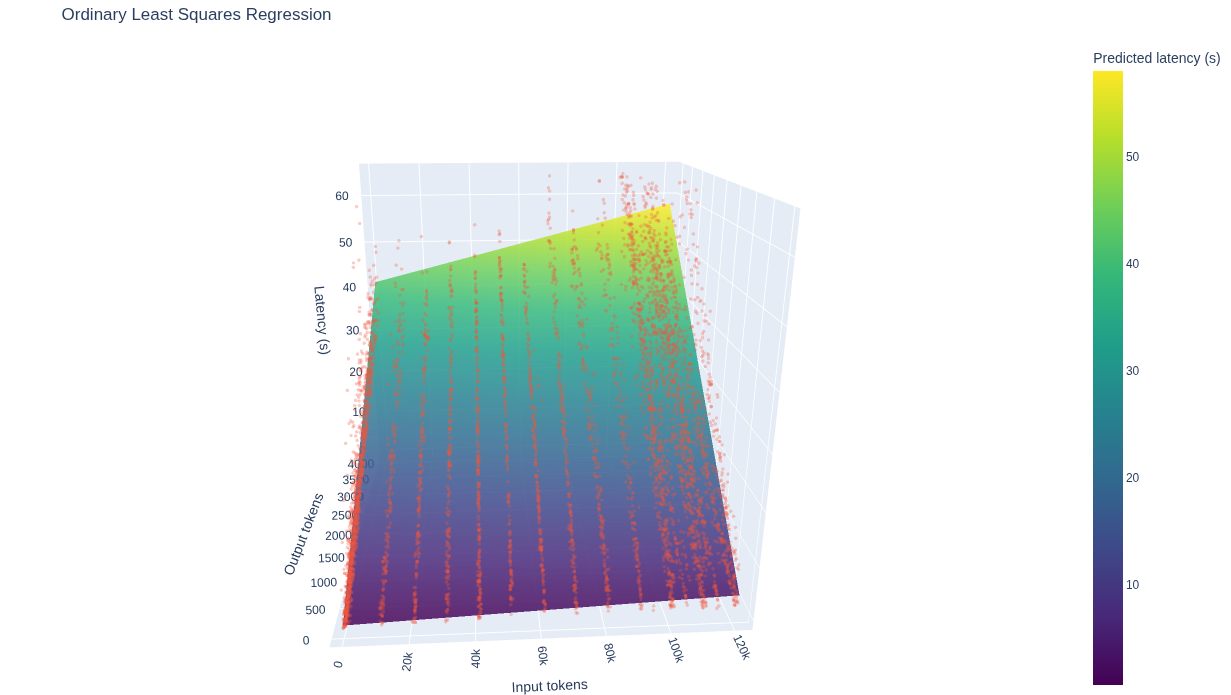

In [5]:
# In case the above interactive display doesn't work
display(Image(filename=folder + "ols_surface_still.png"))
display(Image(filename=folder + "ols_surface_still2.png"))

To summarize, this section outlined why I believe the model reasonably isolates computational latency. By capturing minimal total latency and excluding network overhead, we approximate the lower bound of inference time - effectively isolating compute time. I also showed that latency scales linearly with input and output tokens, and that the interaction effect observed in the data can be captured with an additional term.

Next, I'll show the results: equations that predict total inference time for each model, and how we can use these equations to compare and learn more about the models in relation to each other.

# 3  Results

## 3.1  Data
- Coefficients for each LLM and regression model are recorded in `latency_coefficients.csv`. 
- Individual analyses for each model are found in notebooks named `<model_name>_analysis.ipynb`. 
- Network latency measurements are stored in `network_latency/network_times.json`; a brief analysis is provided in the accompanying notebook `network_latency.ipynb`. 
- Each model's raw data is located in its cooresponding folder. The file `combined_data.csv` merges data from all experimental conditions, namely, `input_token_times.csv`, `output_token_times.csv`, and `mid_token_times.csv`.

## 3.2 Latency coefficients
See data below. `model_name` refers to the exact deployment identifier of the measurement model.
Regression models are referenced using the following shorthand:
- 10% Quantile Regression = `quant`
- Ordinary Least Squares = `ols`

In [6]:
coeffs = pd.read_csv("latency_coefficients.csv")
coeffs[[
    "model_name",
    "quant_r_squared",
    "quant_coef_const",
    "quant_coef_in_k",
    "quant_coef_out_k",
    "quant_coef_in_out_k",
    "ols_r_squared",
    "ols_coef_const",
    "ols_coef_in_k",
    "ols_coef_out_k",
    "ols_coef_in_out_k",
]]

model_name  quant_r_squared  quant_coef_const  quant_coef_in_k  \
0   gpt-4o-2024-05-13         0.701782          0.136489         0.008020   
1          gpt-4-0613         0.751506          0.274285        -0.083023   
2  gpt-3.5-turbo-0125         0.739783          0.087915         0.025147   

   quant_coef_out_k  quant_coef_in_out_k  ols_r_squared  ols_coef_const  \
0          8.350709             0.020060       0.881895        0.668595   
1         22.086689             1.599846       0.959562        1.366364   
2          6.687634             0.051282       0.887563        0.542248   

   ols_coef_in_k  ols_coef_out_k  ols_coef_in_out_k  
0       0.023377        9.970837           0.027340  
1      -0.278164       27.087754           1.906496  
2       0.005316        7.956390           0.117573

All p-values for the coefficients were very near zero.

In [7]:
coeffs.filter(like='pval')


quant_pval_const  quant_pval_in_k  quant_pval_out_k  quant_pval_in_out_k  \
0      0.000000e+00     0.000000e+00               0.0                  0.0   
1     2.308424e-232     1.780618e-99               0.0                  0.0   
2      0.000000e+00     0.000000e+00               0.0                  0.0   

   ols_pval_const  ols_pval_in_k  ols_pval_out_k  ols_pval_in_out_k  
0             0.0   0.000000e+00             0.0                0.0  
1             0.0  1.573154e-188             0.0                0.0  
2             0.0   2.270728e-06             0.0                0.0

To evaluate the latency models, I measured the quantile (pinball) loss on a held-out test set and compared it to a baseline model that predicts the constant 10th percentile from the training data. For all models, the quantile regression approach significantly outperformed the baseline. GPT-4o achieved a test quantile loss of 0.58 (baseline: 1.94), GPT-4 achieved 0.91 (baseline: 3.67), and GPT-3.5 achieved 0.24 (baseline: 0.92). These results demonstrate the effectiveness of the fitted quantile models in capturing variation in low-percentile response times.[\*](#ols-regression-evaluation)

We're now able to estimate the computational latency based on input and output token counts for GPT-4o, GPT-4, and GPT-3.5 Turbo by applying the following equations (using coefficients from the quantile regression):

$$
\text{Compute Latency}_{GPT-4o} = 0.14 + 0.01 \cdot n + 8.35 \cdot m + 0.02 \cdot (n \times m)
$$

$$
\text{Compute Latency}_{GPT-4} = 0.27 - 0.08 \cdot n + 22.09 \cdot m + 1.6 \cdot (n \times m)
$$

$$
\text{Compute Latency}_{GPT-3.5-Turbo} = 0.09 + 0.03 \cdot n + 6.69 \cdot m + 0.05 \cdot (n \times m)
$$

where $n$ and $m$ are measured in thousands of tokens. Note on GPT-4 [\*](#gpt-4s-negative-input-coefficient).

### 3.2.1 Comparing models
The output and interaction coefficients tell us the most about relative latency growth. Output size is the strongest driver of latency, followed by the interaction between input and output sizes, as I'll discuss in the next section. GPT-4 is the slowest model; its output coefficient is around 3 times that of the other models and its interaction coefficient is an order of magnitude larger. In the plot below, we see that the overall latency grows the fastest for GPT-4 as output tokens increase, with input tokens held constant.

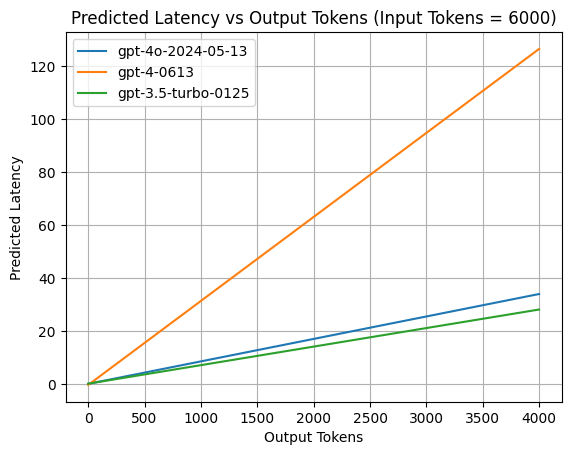

In [8]:
input_tokens = 6000
input_k = input_tokens / 1000
output_tokens = np.linspace(0, 4000, 100)
output_k = output_tokens / 1000

plt.figure()
for model in coeffs['model_name'].unique():
    row = coeffs[coeffs['model_name'] == model].iloc[0]
    const = row['quant_coef_const']
    coef_in = row['quant_coef_in_k']
    coef_out = row['quant_coef_out_k']
    coef_in_out = row['quant_coef_in_out_k']

    preds = const + coef_in * input_k + coef_out * output_k + coef_in_out * input_k * output_k
    plt.plot(output_tokens, preds, label=model)

plt.xlabel('Output Tokens')
plt.ylabel('Predicted Latency')
plt.title(f'Predicted Latency vs Output Tokens (Input Tokens = {input_tokens})')
plt.legend()
plt.grid(True)
plt.show()

### 3.2.2  Impact of the interaction term
To illustrate the impact of the interaction term, the first plot below breaks down total predicted latency into its four components - constant term, input term, output term, and interaction term - using Quantile Regression coefficients for each model.

I chose three representative input token values (including the maximum supported input) and held output tokens fixed at 2,000. As expected, the output term dominates latency; the interaction term is the second-largest contributor and grows visibly larger as input tokens increase. The accompanying table shows the plotted values for GPT-4o. For example, a short, 1,000-token prompt generating 2000 output tokens takes roughly 17 seconds, whereas a 126,000-token prompt (near the 128,000 token limit) generating the same 2,000-token response takes 23 seconds, a 35% increase.

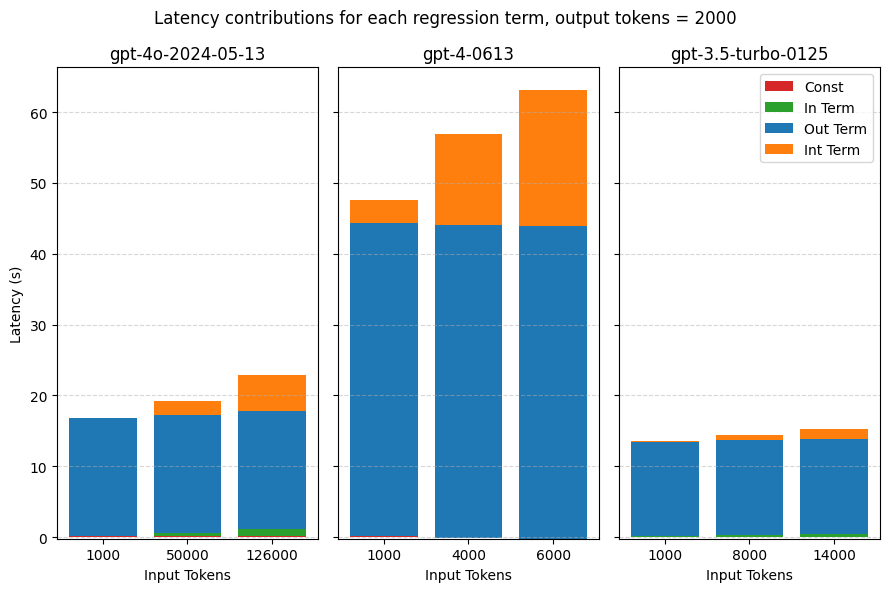

In [9]:
input_tokens_map = {
    "gpt-4o-2024-05-13": [1000, 50000, 126000],
    "gpt-4-0613": [1000, 4000, 6000],
    "gpt-3.5-turbo-0125": [1000, 8000, 14000],
}
output_tokens = 2000

contrib_by_model = plot_latency_contributions_by_term(input_tokens_map, output_tokens, coeffs)

In [10]:
gpt_4o_df = contrib_by_model['gpt-4o-2024-05-13']
gpt_4o_df['total_latency'] = gpt_4o_df[['const', 'in_term', 'out_term', 'int_term']].sum(axis=1)
gpt_4o_df

const   in_term   out_term  int_term  total_latency
input_tokens                                                        
1000          0.136489  0.008020  16.701417  0.040119      16.886046
50000         0.136489  0.400992  16.701417  2.005965      19.244863
126000        0.136489  1.010501  16.701417  5.055031      22.903438

This second plot shows how the interaction term's contribution increases as output tokens grow, with input fixed at 6,000 tokens. (All three models can handle up to 6,000 input + 2,000 output tokens; GPT-4’s 8,000 token limit is the tightest.) Here we see that GPT-4 exhibits the largest interaction effect by far, which is consistent with its estimated position as the biggest model in this study.

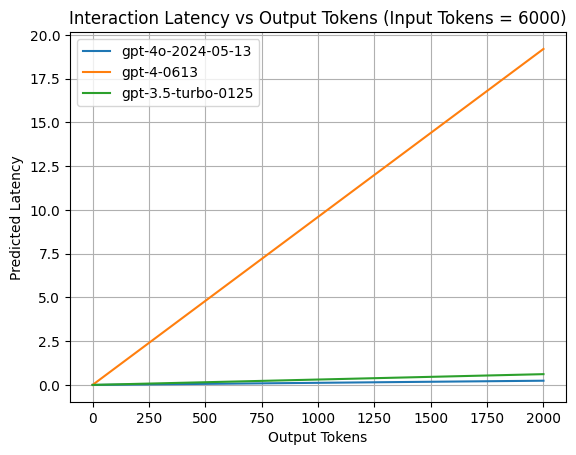

In [11]:
input_tokens = 6000
input_k = input_tokens / 1000
output_tokens = np.linspace(0, 2000, 100)
output_k = output_tokens / 1000

plt.figure()
for model in coeffs['model_name'].unique():
    row = coeffs[coeffs['model_name'] == model].iloc[0]
    coef_in_out = row['quant_coef_in_out_k']

    preds = coef_in_out * input_k * output_k
    plt.plot(output_tokens, preds, label=model)

plt.xlabel('Output Tokens')
plt.ylabel('Predicted Latency')
plt.title(f'Interaction Latency vs Output Tokens (Input Tokens = {input_tokens})')
plt.legend()
plt.grid(True)
plt.show()


---

# 4  Discussion

## 4.1  Latency as a proxy for model size
Although extending this model to estimate emissions remains an open question, latency and cost may serve as proxies for comparing models and inferring their relative sizes. According to Microsoft, "smaller models often offer faster processing and lower costs, while larger models provide enhanced understanding and performance on complex tasks but require more resources"¹ ([Shone, 2024](https://www.microsoft.com/en-us/microsoft-cloud/blog/2024/11/11/explore-ai-models-key-differences-between-small-language-models-and-large-language-models/#:~:text=Smaller%20models%20often%20offer%20faster,tasks%20but%20require%20more%20resources.)). Additionally, smaller models (by parameter count) tend to consume less energy than larger models ([Li, et al., 2024](https://aclanthology.org/2024.emnlp-main.1215/)). The correlation between model size and latency was also corroborated by [EcoLogits](https://ecologits.ai/0.4/methodology/llm_inference/#estimating-the-generation-latency) analysis on the [LLM Perf Leaderboard](https://huggingface.co/spaces/optimum/llm-perf-leaderboard) dataset, which benchmarks open-source performance metrics such as latency and energy consumption. Together, these findings reinforce that latency is indicative of model scale and resource usage.

### 4.1.1  Proxies agree on relative model size
The table below lists values for proxy measures latency and price, along with the estimated active parameters for each model². I use the output term from the Quantile Regression for each model as that term has the largest impact on latency.

| Model | Output coefficient (Quantile Regression) | Price²³ ($ per million input/output tokens) | Estimated Active Parameters |
| --- | --- | --- | --- |
| GPT-4 | 22.1 | 30/60 | 220B-880B |
| GPT-4o | 8.4 | 2.5/10 | 55B-220B |
| GPT-3.5-Turbo | 6.7 | 0.5/1.5 | 20B-70B |

The proxy measures align with estimated relative active parameters. GPT-4 is up to 16 times larger than GPT-4o by active-parameter count, and it is about 3 times slower per output token; input tokens cost 12 times more, and output tokens cost 6 times more. GPT-4o is larger than GPT-3.5-Turbo, though by a smaller factor than GPT-4 is larger than GPT-4o. Specifically, GPT-4o is up to 11 times larger than GPT-3.5-Turbo; input tokens cost 5 times more, and output tokens cost 7 times more. One might expect a larger latency gap between GPT-4o and GPT-3.5-Turbo, given their cost differences. However, GPT-4o likely runs on newer, faster H200 or H100 GPUs, whereas older models like GPT-3.5-Turbo and GPT-4 likely still use A100s ([Jegham et al., 2025](https://arxiv.org/abs/2505.09598)). If all models ran on the H200/H100 GPUs, the latencies for GPT-4 and GPT-3.5-Turbo would decrease. In that case, the latency gap between GPT-4o and GPT-4 would narrow, while the gap between GPT-4o and GPT-3.5-Turbo would widen, bringing relative latencies more in line with relative costs and model sizes.

While proxies can give us a rough idea of the resource usage of models in relation to each other, concrete values or ranges for energy consumption and emissions are far more useful. In the next section, I survey existing and emerging efforts to estimate emissions from closed-source models and outline the key gaps that must be addressed to produce reliable estimates from latency.

---

¹Batching and hardware differences also affect latency, so the relationship between latency and model size is not strictly one-to-one.

²Taken from a spreadsheet compiled and maintained by EcoLogits estimating the active parameters of proprietary/closed-source models ([EcoLogits - "About Proprietary Models"](https://ecologits.ai/latest/methodology/proprietary_models/)).

³Data compiled from OpenAI model cards for [GPT-4](https://platform.openai.com/docs/models/gpt-4), [GPT-4o](https://platform.openai.com/docs/models/gpt-4o), and [GPT-3.5-turbo](https://platform.openai.com/docs/models/gpt-3.5-turbo).


---

# 5  Estimating Emissions
The original motivation for this latency model was to extend it to estimate emissions, given that closed-source models generally lack transparency around their emissions. Latency, however, is measurable and correlates with compute time, which drives data center energy use and associated emissions. Many assumptions are required to convert latency into emissions. In this section, I outline a theoretical framework for using this model to estimate emissions, summarizing the current literature. Implementation is left for future work, pending broader consensus on the necessary assumptions.

### 5.1  Estimating power draw from computational latency
Starting with our estimate of computational latency or total inference time, the next step towards emissions estimation is to estimate GPU power draw during that interval. Many factors influence GPU power draw, each requiring its own set of assumptions. For example, hardware type, utilization level, and cooling efficiency all play a role. Although prior studies suggest plausible ranges for certain parameters, power-draw estimation remains highly uncertain - especially since the exact hardware and its configuration are not publicly disclosed.

**What hardware is being used?** Current hyperscale datacenters (e.g., those used by OpenAI) typically employ NVIDIA DGX A100, H100, H200, and H800 GPUs. Benchmarks indicate that A100s are being gradually supplanted by the more efficient H100/H200; however, older models like GPT-4 and GPT-3.5-Turbo may still run on A100s ([Jegham et al., 2025](https://arxiv.org/abs/2505.09598)).

**How many GPUs are being used to serve the model?** Small models (under 20 B parameters) can run on a single GPU, whereas larger models require multiple GPUs, increasing energy consumption. Jegham et al. ([2025](https://arxiv.org/abs/2505.09598)) classified model sizes as "Nano (<7B), Micro (7–20B), Small (20–40B), Medium (40–70B), and Large (>70B), assigning 1, 2, 4, or 8 GPUs accordingly" and relied on estimates of model parameter counts to assign size classes to the proprietary models they studied.

**How much power are the GPUs drawing during inference?** The prefill phase typically maximizes GPU utilization, but utilization drops during decoding. To mitigate this, deployments batch requests so that the GPUs process multiple decodes concurrently. Batching increases instantaneous power draw, but because multiple requests share the GPUs simultaneously, the per-request energy cost is amortized. Batch size represents a trade-off: "small batches are fast but don't utilize the hardware well. Big batches are slow but efficient" ([Austin, et al., 2025](https://jax-ml.github.io/scaling-book/inference/)). Since user experience is optimized when token generation is faster than reading speed, deployments often prioritize reduced latency over efficiency of throughput. Although deployments adjust batch sizes dynamically based on traffic, Jegham et al. ([2025](https://arxiv.org/abs/2505.09598)) adopted a batch size of 8 as it represented "a practical midpoint between common deployment scenarios." They then extrapolated per-GPU power consumption from open-source benchmarks to estimate energy use for closed-source models assumed to run on similar hardware and GPU counts.

**How efficient is the data center?** Once the inference power draw from the GPUs is estimated, total data center energy use can be approximated by scaling this estimate by the Power Usage Effectiveness (PUE) of the facility. PUE accounts for non-computational overheads, such as cooling and power distribution. A PUE of 1 represents perfect efficiency (i.e., all energy is used for computation). Microsoft Azure's hyperscale datacenters, which currently host OpenAI's workloads, report a PUE of 1.12 ([Walsh-Elwell, 2022](https://azure.microsoft.com/en-us/blog/how-microsoft-measures-datacenter-water-and-energy-use-to-improve-azure-cloud-sustainability/); [Microsoft, 2025](https://blogs.microsoft.com/blog/2025/01/21/microsoft-and-openai-evolve-partnership-to-drive-the-next-phase-of-ai/)).

The key parameters needed to model energy consumption during inference are as follows: average GPU power draw, the number of GPUs required, and batch size. The function $P(W,G,B)$ models power draw per unit time and is defined in detail by Jegham et al. ([2025](https://arxiv.org/abs/2505.09598)). In this work, I use a simplified abstraction:

$$
E = T \cdot P(W, G, B) \cdot PUE
$$

where:
- $E$ is the total energy consumed (kilowatt-hours, kWh)
- $T$ is the total inference time (hours)
- $P(W,G,B)$ average power draw (in kilowatts), modeled as a function of:
    - $W$: power draw of a single GPU
    - $G$: number of GPUs required to serve the model
    - $B$: batch size
- $PUE$: Power Usage Effectiveness

### 5.2  Estimating emissions from energy consumption
Once total[\*](#embodied-carbon) energy consumption is known, emissions can be estimated by multiplying by the emission factor (also called carbon intensity) of the grid powering the data center. The emission factor (in gCO₂eq/kWh) converts energy use into carbon emissions and varies by location. Low-carbon grids, such as California's (with substantial wind and solar), have smaller emission factors¹. Since Azure may route requests across US sites, one can use the US average which was approximately 367 gCO₂eq/kWh in 2023 ([EIA, 2024](https://www.eia.gov/tools/faqs/faq.php?id=74&t=11)).

Thus, the final model of carbon emissions can be described by:

$$
C = \underbrace{T \cdot P(W, G, B) \cdot PUE}_{\text{Energy (kWh)}} \cdot F
$$

where $C$ is the total carbon emitted (gCO₂eq) and $F$ is the emission factor.

The function $P(W, G, B)$ is the missing link needed to fully estimate emissions from latency. Jegham et al. ([2025](https://arxiv.org/abs/2505.09598)) developed a GPU power model based on empirical data from prior studies, but the full data needed to apply it here is not currently public. I leave to future work the task of replicating their emissions model, substituting in the updated latency model presented here. Notably, theirs is the first paper I’ve encountered that uses assumptions about infrastructure setup to estimate emissions from latency. While these assumptions are supported by empirical studies, the field is still developing, and the level of certainty varies by parameter. Some values are well-supported, while others remain uncertain.

---

¹You can compare the emission factor in different locations in real-time by visiting ([Electricity Maps](https://app.electricitymaps.com/map/24h)).


---

# 6  Conclusion

This work reveals that latency scales with both input and output size and that a nonzero interaction implies extra delay when both are large. This challenges models that assume a constant TTFT or treat the cost of input tokens as negligible. Because conversational contexts inject additional input tokens behind the scenes, token-based emissions or energy models risk dramatic underestimation if these aren't accounted for.

The original motivation for this model was to support emissions estimates. However, given there's currently no transparency from OpenAI (and other GenAI vendors) and a lack of consensus on key assumptions, rigorous accounting remains difficult. The key missing piece is a comprehensive model of the hardware power draw during inference. While some parameters are better understood, others are less clear, such as the number of GPUs required to serve a model whose architecture and size are undisclosed. As another example, a notable omission in both this analysis and prior work (as far as I’m aware) is how to account for overprovisioned GPUs that stay powered even when idle, continuing to draw energy and produce emissions. Too many GPUs sitting idle would be costly, but some idle capacity is inevitable. Without insight into production setup, accurately quantifying this is nearly impossible. Directional estimates are valuable and can be constructed using plausible assumptions, but a fully accurate infrastructual power model is infeasible without visibility into vendor operations.

So, as researchers attempt to measure closed-source GenAI model emissions externally, we must all also collectively **push for greater transparency**. HuggingFace's [AI Energy Score project](https://huggingface.co/AIEnergyScore), led by Dr. Sasha Luccioni, spearheads this effort. The project's goal is to create a standard for comparing energy efficiency ratings of AI models, and so far, no closed-source vendors have submitted models. We must continue to pressure companies for transparency by:
1. Choosing models deliberately;
2. Examining how and how often we use them;
3. Leveraging our positions via awareness campaigns, research, advocacy, and direct engagement with tech vendors.

**Current and future generations deserve technology that is built and deployed sustainably.**

---

#### Citation:

```bibtex
@misc{campbell2025latency,
  author = {Faryn Campbell},
  title = {What Latency Can Tell Us About Emissions in Closed-Source LLMs: A Partial Model and a Call for Transparency},
  year = {2025},
  month = {July},
  url = {https://github.com/FarynWoods/openai-latency-regression},
  doi = {10.5281/zenodo.INSERT_DOI_HERE},
  license = {GNU GPL V3},
  note = {GitHub repository}
}
```


### Acknowledgments
Portions of this work were completed during designated learning hours provided by my employer, Crowe. I also used my OpenAI account through Crowe to collect the data. I'm grateful for their support of this work.

Additionally, I thank the students in Emma Strubell’s research lab at Carnegie Mellon for their feedback on the experimental design, and Jim Ulbright for his comments on the manuscript draft.

### Disclaimer
**Views expressed in this work are solely my own and do not express the views or opinions of my employer.**

### Emissions Statement
A very rough estimate of the emissions resulting from conducting all experiments is calculated below. Given that the experimental data is fully available, this estimate can be refined as emissions estimation methodology improves.

#### Assumptions
- Uses the 1k input - 1k output energy consumption estimate from Jegham et al. ([2025](https://arxiv.org/abs/2505.09598)) Table 4, divided by 1000 to get the "per output token" energy consumption rate. Assumes that impact scales linearly with output tokens.
- Impact of growing input tokens is largely ignored
- Uses same energy consumption data for GPT-3.5 Turbo as is reported for GPT-4o, given lack of data
- Accounts only for energy draw of actively assigned GPUs (over-provisioned, unused GPU power ignored), and PUE of data center
- Assumed US average emission factor: 0.367gCO2/Wh

In [12]:
models = ['gpt-3.5-turbo-0125', 'gpt-4-0613', 'gpt-4o-2024-05-13']
EMISSION_FACTOR = 0.367  # gCO2/Wh

def compute_energy_range(row):
    mean, std = energy_per_output_token[row['model_name']]
    tokens = row['output_tokens']
    low = tokens * (mean - std)
    high = tokens * (mean + std)
    return (low, high)

def compute_emissions(row):
    low_wh, high_wh = row['energy_estimate_Wh']
    return (low_wh * EMISSION_FACTOR, high_wh * EMISSION_FACTOR)

# Collect all experimental data
dataframes = []
for model in models:
    model_data = pd.read_csv(model + '/combined_data.csv')
    model_data['model_name'] = model
    dataframes.append(model_data)

combined_data = pd.concat(dataframes, ignore_index=True)

# Numbers from Jegham et al., Table 4
energy_per_output_token = {
    "gpt-4o-2024-05-13": (0.001214, 0.000391),
    "gpt-4-0613": (0.006512, 0.001501),
    "gpt-3.5-turbo-0125": (0.001214, 0.000391)
}

combined_data['energy_estimate_Wh'] = combined_data.apply(compute_energy_range, axis=1)
combined_data['emission_estimate_g'] = combined_data.apply(compute_emissions, axis=1)

low_estimates, high_estimates = zip(*combined_data['emission_estimate_g'])

total_low = sum(low_estimates)
total_high = sum(high_estimates)

print(f"Total CO2 emissions estimate: {total_low:.2f} g to {total_high:.2f} g")

Total CO2 emissions estimate: 3266.62 g to 5705.61 g


### Use of LLM Assistance
ChatGPT was used to assist in the preparation of this work in the following ways:
1. Generated figure code using ChatGPT, then reviewed and tested it for functionality.
2. Generated type annotations and docstrings for `token_latency_functions.py` using ChatGPT, then reviewed and refined them.
3. This manuscript was written by Faryn Campbell. After it was composed, sections were submitted to ChatGPT for minor clarity edits, which were reviewed and incorporated as needed.

The author takes full responsibility for the content of this work.

# References

In [13]:
with open('references.md', 'r') as file:
    content = file.read()

display(Markdown(content))

Altman, Sam. 2025. “The Gentle Singularity.”
<https://blog.samaltman.com/the-gentle-singularity>.

Artificial Analysis. 2025. “Artificial Analysis: AI Model & API
Providers Analysis.” <https://artificialanalysis.ai/>.

Austin, Jacob, Sholto Douglas, Roy Frostig, Anselm Levskaya, Charlie
Chen, Sharad Vikram, Federico Lebron, et al. 2025. “How to Scale Your
Model.”

Delavande, Julien. 2025. “I Asked Qwen3-8B to Think — It Answered Right,
but at What Cost?”
<https://www.linkedin.com/posts/juliendelavande_i-asked-qwen3-8b-to-think-it-answered-activity-7323056592050921472-pdaP/>.

EcoLogits. 2025a. “About Proprietary Models.”
<https://ecologits.ai/latest/methodology/proprietary_models/>.

———. 2025b. “Environmental Impacts of LLM Inference.”
<https://ecologits.ai/0.4/methodology/llm_inference/>.

Electricity Maps. 2025. “Live 24/7 CO₂ Emissions of Electricity
Consumption.” <https://app.electricitymaps.com/map/72h/hourly>.

GenAI Impact. 2025. “EcoLogits Calculator.”
<https://huggingface.co/spaces/genai-impact/ecologits-calculator>.

Google DeepMind. n.d. “Gemini 2.5 Pro.”
<https://deepmind.google/models/gemini/pro/>.

Hugging Face. 2025. “AI Energy Score.”
<https://huggingface.co/AIEnergyScore>.

Jegham, Nidhal, Marwen Abdelatti, Lassad Elmoubarki, and Abdeltawab
Hendawi. 2025. “How Hungry Is AI? Benchmarking Energy, Water, and Carbon
Footprint of LLM Inference.” *arXiv Preprint arXiv:2505.09598*, May.
<https://arxiv.org/abs/2505.09598>.

Lee, Benjamin C., David Brooks, Arthur van Benthem, Udit Gupta, Gage
Hills, Vincent Liu, Benjamin Pierce, et al. 2024. “Carbon Connect: An
Ecosystem for Sustainable Computing.” *arXiv Preprint arXiv:2405.13858*.
<https://arxiv.org/abs/2405.13858>.

Li, Baolin, Yankai Jiang, Vijay Gadepally, and Devesh Tiwari. 2024.
“Sprout: Green Generative AI with Carbon-Efficient LLM Inference.” In
*Proceedings of the 2024 Conference on Empirical Methods in Natural
Language Processing*, 21799–813. Miami, Florida, USA: Association for
Computational Linguistics.
<https://doi.org/10.18653/v1/2024.emnlp-main.1215>.

Luccioni, Alexandra Sasha, Emma Strubell, and Kate Crawford. 2025. “From
Efficiency Gains to Rebound Effects: The Problem of Jevons’ Paradox in
AI’s Polarized Environmental Debate.” *arXiv Preprint arXiv:2501.16548*.
<https://arxiv.org/abs/2501.16548>.

Luccioni, Sasha, and Boris Gamazaychikov. 2025. “AI Models Hiding Their
Energy Footprint? Here’s What You Can Do.”
<https://huggingface.co/blog/sasha/energy-score-call-to-action>.

Luccioni, Sasha, Boris Gamazaychikov, Theo Alves da Costa, and Emma
Strubell. 2025. “Misinformation by Omission: The Need for More
Environmental Transparency in AI.” *arXiv Preprint arXiv:2506.15572*.
<https://arxiv.org/abs/2506.15572>.

Luccioni, Sasha, Bruna Trevelin, and Margaret Mitchell. 2024. “The
Environmental Impacts of AI – Policy Primer.” In *Hugging Face Blog*.
<https://doi.org/10.57967/hf/3004>.

Microsoft Corporation. 2024. “Explore AI Models: Key Differences Between
Small Language Models and Large Language Models.”
<https://www.microsoft.com/en-us/microsoft-cloud/blog/2024/11/11/explore-ai-models-key-differences-between-small-language-models-and-large-language-models/>.

———. 2025. “Microsoft and OpenAI Evolve Partnership to Drive the Next
Phase of AI.”
<https://blogs.microsoft.com/blog/2025/01/21/microsoft-and-openai-evolve-partnership-to-drive-the-next-phase-of-ai/>.

O’Donnell, James, and Casey Crownhart. 2025. “We Did the Math on AI’s
Energy Footprint. Here’s the Story You Haven’t Heard.”
<https://www.technologyreview.com/2025/05/20/1116327/ai-energy-usage-climate-footprint-big-tech/>.

OpenAI. 2024. “Memory and New Controls for ChatGPT.”
<https://openai.com/index/memory-and-new-controls-for-chatgpt/>.

———. 2025a. “GPT-3.5 Turbo Model Documentation.”
<https://platform.openai.com/docs/models/gpt-3.5-turbo>.

———. 2025b. “GPT-4 Model Documentation.”
<https://platform.openai.com/docs/models/gpt-4>.

———. 2025c. “GPT-4o Model Documentation.”
<https://platform.openai.com/docs/models/gpt-4o>.

Paris, Martine. 2025. “ChatGPT Hits 1 Billion Users? ’Doubled in Just
Weeks’ Says OpenAI CEO.”
<https://www.forbes.com/sites/martineparis/2025/04/12/chatgpt-hits-1-billion-users-openai-ceo-says-doubled-in-weeks/>.

Strubell, Emma, Ananya Ganesh, and Andrew McCallum. 2019. “Energy and
Policy Considerations for Deep Learning in NLP.” *arXiv Preprint
arXiv:1906.02243*. <https://arxiv.org/abs/1906.02243>.

U.S. Energy Information Administration. 2024. “How Much Carbon Dioxide
Is Produced Per Kilowatthour of u.s. Electricity Generation?”
<https://www.eia.gov/tools/faqs/faq.php?id=74&t=11>.

Vries, Alex de. 2023. “The Growing Energy Footprint of Artificial
Intelligence.” *Joule* 7 (10): 2191–94.
<https://doi.org/10.1016/j.joule.2023.09.004>.

Walsh-Elwell, Noelle. 2022. “How Microsoft Measures Datacenter Water and
Energy Use to Improve Azure Cloud Sustainability.”
<https://azure.microsoft.com/en-us/blog/how-microsoft-measures-datacenter-water-and-energy-use-to-improve-azure-cloud-sustainability/>.

Werra, Leandro von, Lewis Tunstall, Quentin Gallouédec, Guilherme
Penedo, Edward Beeching, Anton Lozhkov, Brigitte Tousignant, and Daniel
van Strien. 2025. “Open-R1: Update \#1.”
<https://huggingface.co/blog/open-r1/update-1>.

Wu, Carole-Jean, Ramya Raghavendra, Udit Gupta, Bilge Acun, Newsha
Ardalani, Kiwan Maeng, Gloria Chang, et al. 2022. “Sustainable AI:
Environmental Implications, Challenges and Opportunities.” *arXiv
Preprint arXiv:2111.00364*. <https://arxiv.org/abs/2111.00364>.

You, Josh. 2025. “How Much Energy Does ChatGPT Use?”
<https://epoch.ai/gradient-updates/how-much-energy-does-chatgpt-use>.


# Appendix

### Computational Latency
> In the framework I've written above, the only source of variation in overall response latency for the same inputs and number of output tokens is network latency. The computational latency, in this estimation framework, should not vary on repeated runs.

In practice, however, dynamic batching introduces variability: individual requests may experience different computational latencies depending on the batch they are processed with. Still, over many runs, the average computational latency should converge based on the average batch size.

[Back to "Network Latency"](#211-network-latency)

### OLS Regression Evaluation
While the Quantile Regression is key to the theoretical framing of this approach, the OLS model also consistently outperformed a constant baseline in terms of mean squared error (MSE). For GPT-4o, the model achieved a test MSE of 26.57 (baseline: 224.60); for GPT-4, 46.31 (baseline: 1143.84); and for GPT-3.5, 6.90 (baseline: 62.03).

[Back to "Latency Coefficients"](#32-latency-coefficients)

### GPT-4's negative input coefficient
While the interaction term is well-motivated by the underlying attention mechanism, its inclusion resulted in a slightly negative coefficient for the linear input term in the quantile regression model for GPT-4. This likely reflects overlapping variance explained by the interaction term at high input and output lengths. Since such a negative coefficient contradicts architectural expectations, I interpret this as an artifact of model fitting rather than an indication that additional input tokens reduce computational latency.

[Back to "Comparing Models"](#321-comparing-models)

### Embodied Carbon
A complete inventory of energy use and emissions is extremely challenging. For example, the emissions from manufacturing hardware and infrastructure (embodied carbon) are excluded here, yet "embodied carbon from semiconductor manufacturing is a major contributor to emissions" ([Lee et al., 2024](https://arxiv.org/abs/2405.13858)). One study found that including embodied carbon for a Meta-trained LLM doubled its carbon footprint ([Wu, et al., 2022](https://arxiv.org/abs/2111.00364)).

[Back to "Estimating Emissions from Energy Consumption"](#52-estimating-emissions-from-energy-consumption)